https://www.nature.com/articles/s41467-024-44824-z

In [1]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

^C
ERROR: Operation cancelled by user


In [40]:
import os
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

import torch
import torch.nn.functional as F
from skimage import transform
from segment_anything import sam_model_registry

# Utility functions

## Open dicom folder

In [41]:
def read_dicomdir(dir_path: str) -> list:
    # opening the dicom files in the dir
    dicom_files = [
        os.path.join(dir_path, f) 
        for f in os.listdir(dir_path)
    ]
    
    # Sort the files based on slice location (for this patient is already done)
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)
    
    # read the actual dicom files
    slices = [pydicom.dcmread(f) for f in dicom_files]
    
    return slices

## Reconstruct 3d shape

In [42]:
def get_3d_shape(dicom_slices: list) -> np.ndarray:
    pixel_arrays = [s.pixel_array for s in dicom_slices]

    # stack the slices to create a 3d array
    volume_3d = np.stack(pixel_arrays, axis=0)
    
    # flip the dicom on the vertical axis
    return volume_3d[:, ::-1, :]

# Load up lesions dataframe

In [43]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
df["Pixel Spacing"] = [ read_dicomdir(dicom_path)[0].PixelSpacing[0] for dicom_path in df["Registered Ax T2 FSE path"] ]
df["x_indexes"] = df["x_indexes"].apply(ast.literal_eval)
df["y_indexes"] = df["y_indexes"].apply(ast.literal_eval)

In [6]:
df[["Patient ID", "tumor/benign", "Breast"]]

,Patient ID,tumor/benign,Breast
0,AMBL-001,1.0,L
1,AMBL-001,1.0,R
12,AMBL-003,1.0,R
18,AMBL-004,0.0,L
24,AMBL-005,1.0,R
...,...,...,...
1179,AMBL-629,0.0,R
1180,AMBL-629,0.0,R
1181,AMBL-629,0.0,R
1188,AMBL-631,1.0,L


In [7]:
df[df["Patient ID"] == "AMBL-496"]

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Numpy Filepath,Pixel Spacing
708,AMBL-496,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-15.98,L,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[151, 152, 153, 154, 155, 156, 157, 158, 159, ...","[104, 105, 106, 107, 108, 109, 110, 111, 112, ...",31,76,56,/media/bendico765/Crucial X9/MRI Lesions/np_fi...,0.6445


# MEDSAM model

In [44]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [45]:
def get_medsam_seg(medsam_model, img_slice, seg_box):
    size = 1024
    img_3c = np.repeat(img_slice[:,:,None],3, axis=-1) # ( H, W, 3 )
    H, W, _ = img_3c.shape

    # resize to size x size
    img = transform.resize(img_3c, (size, size), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img = (img - img.min()) / np.clip(
        img.max() - img.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)

    # convert the shape to (3, H, W)
    img_tensor = torch.tensor(img).float().permute(2, 0, 1).unsqueeze(0).to(device) # (1,3,size,size)

    # transfer seg_box to sizexsize scale
    box = seg_box / np.array([W, H, W, H]) * size
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_tensor) # (1, 256, 64, 64)
    
    return medsam_inference(medsam_model, image_embedding, box, H, W)

In [46]:
MedSAM_CKPT_PATH = "sam_vit_b_01ec64.pth"
device = "cpu"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

/home/bendico765/anaconda3/envs/tesi/lib/python3.9/site-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, 

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## Patient AMBL-001

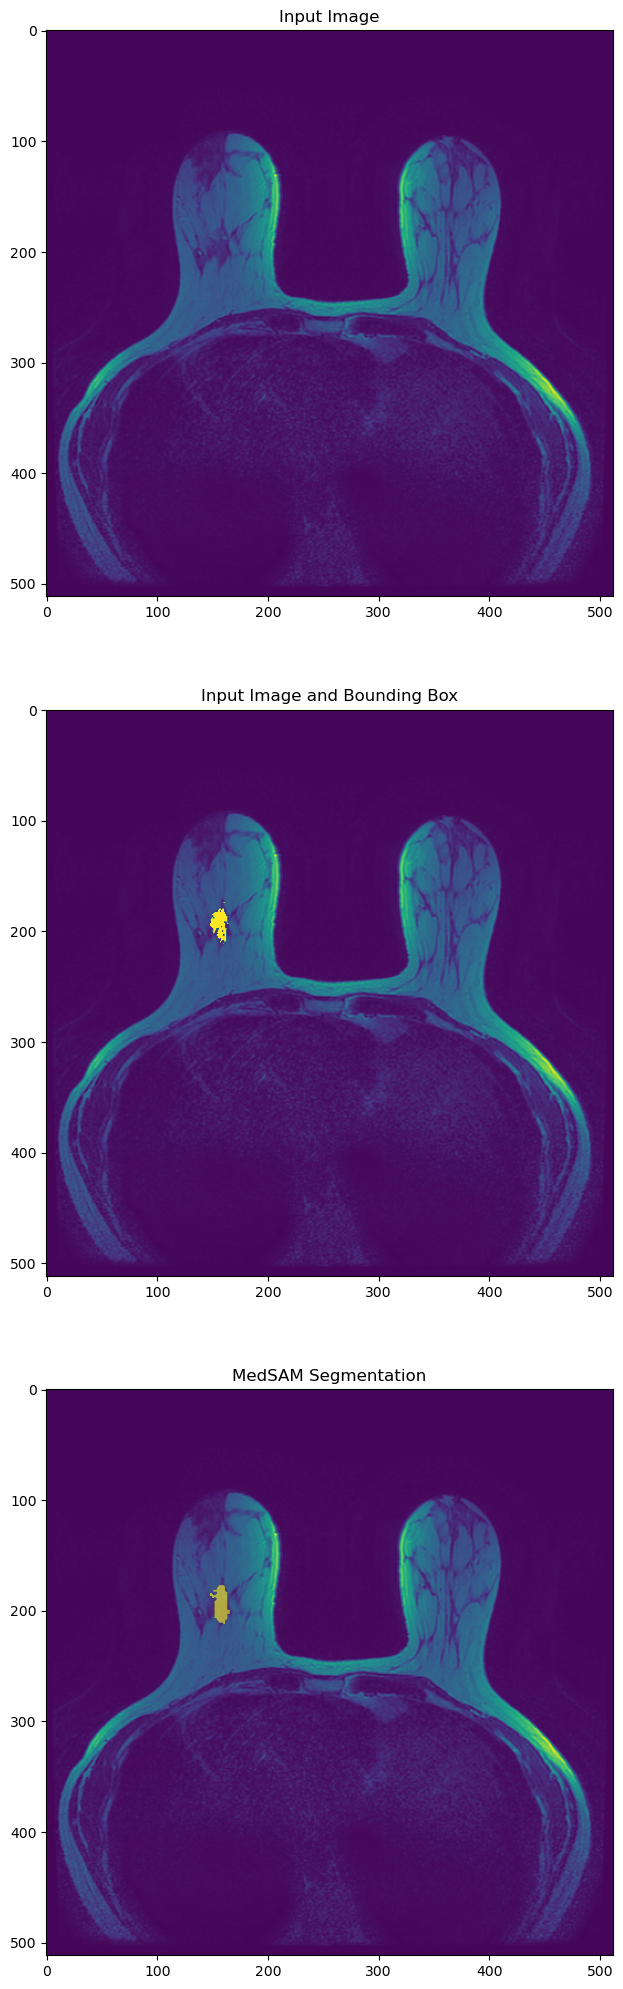

In [35]:
patient_index = 0
z = 83

v = np.load(df.at[patient_index, "Numpy Filepath"])
img_slice = get_3d_shape(read_dicomdir(df.at[patient_index, "Registered Ax T2 FSE path"]))[z]
mask_slice = v[z]
pixel_spacing = df.at[patient_index, "Pixel Spacing"]
non_zero_indices = np.argwhere(mask_slice != 0)

seg_box = np.array([[
    min(non_zero_indices[:,1]), # x_0
    min(non_zero_indices[:,0]), # y_0
    max(non_zero_indices[:,1]), # x_1
    max(non_zero_indices[:,0])  # y_1
]])

medsam_seg = get_medsam_seg(medsam_model, img_slice, seg_box)

#%% visualize results
fig, ax = plt.subplots(3, 1, figsize=(25, 25))
ax[0].imshow(img_slice)
ax[0].set_title("Input Image")

ax[1].imshow(img_slice)
ax[1].imshow(mask_slice, alpha= (mask_slice != 0).astype(float))
show_box(seg_box[0], ax[1])
ax[1].set_title("Input Image and Bounding Box")

ax[2].imshow(img_slice)
show_mask(medsam_seg, ax[2])
#show_box(box_np[0], ax[1])
ax[2].set_title("MedSAM Segmentation")

plt.show()

## Patient 496

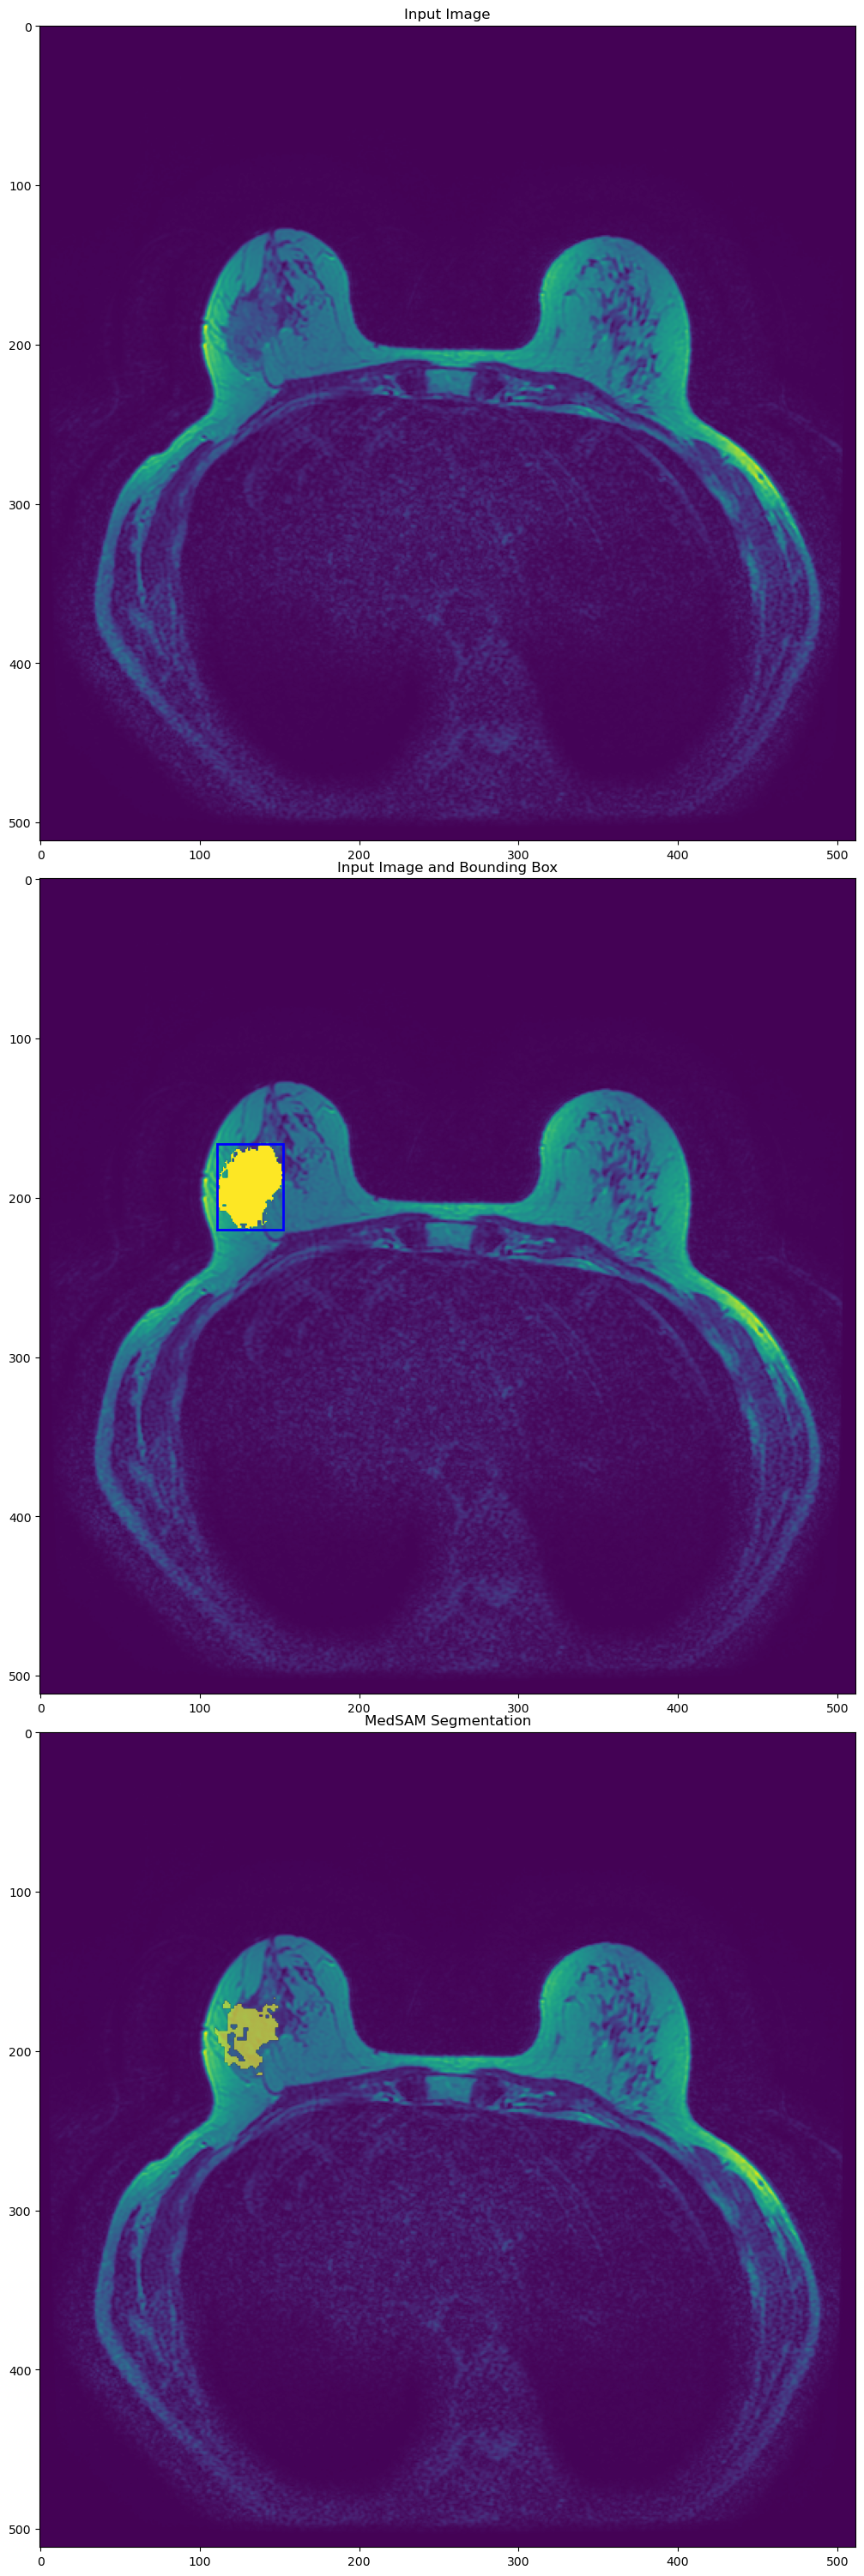

In [47]:
patient_index = 708
z = 69

v = np.load(df.at[patient_index, "Numpy Filepath"])
img_slice = get_3d_shape(read_dicomdir(df.at[patient_index, "Registered Ax T2 FSE path"]))[z]
mask_slice = v[z]
pixel_spacing = df.at[patient_index, "Pixel Spacing"]
non_zero_indices = np.argwhere(mask_slice != 0)
#x_indexes = df.at[patient_index, "x_indexes"]
#y_indexes = df.at[patient_index, "y_indexes"]

seg_box = np.array([[
    min(non_zero_indices[:,1]), # x_0
    min(non_zero_indices[:,0]), # y_0
    max(non_zero_indices[:,1]), # x_1
    max(non_zero_indices[:,0])  # y_1
]])

medsam_seg = get_medsam_seg(medsam_model, img_slice, seg_box)

#%% visualize results
fig, ax = plt.subplots(3, 1, figsize=(30, 30))
fig.tight_layout()

ax[0].imshow(img_slice)
ax[0].set_title("Input Image")

ax[1].imshow(img_slice)
ax[1].imshow(mask_slice, alpha= (mask_slice != 0).astype(float))
show_box(seg_box[0], ax[1])
ax[1].set_title("Input Image and Bounding Box")

ax[2].imshow(img_slice)
show_mask(medsam_seg, ax[2])
#show_box(box_np[0], ax[1])
ax[2].set_title("MedSAM Segmentation")
plt.show()